In [41]:
import numpy as np
from tensorflow import keras
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import matplotlib.patches as patches
from sklearn.preprocessing import MinMaxScaler
import copy
from tqdm.notebook import tqdm

In [43]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon_large_more_concepts.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

#Load behaviour policy
pi_b = keras.models.load_model("saved_models/pi_b_10")

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(5438,)
(5438,)
(5438,)
(5438,)
(5438,)
(10, 2)
(500, 2)


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

class WindModel():
    def __init__(self, input_size, num_actions) -> None:
        self.input_size = input_size
        self.output_size = num_actions
    
    def build(self):
        model = Sequential()
        model.add(Dense(64, activation="relu", input_shape=self.input_size))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_size, activation="linear"))

        model.compile(optimizer='adam',loss="mse", metrics=["mse"])
        return model

In [5]:
# rewards_to_go = []
# for traj in trajectories:
#     rewards_to_go.append(-np.arange(len(traj),0,-1)) #the reward to go


# X = np.concatenate(trajectories)
# print(X.shape)
# Y = np.concatenate(rewards_to_go)
# print(Y.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# print(X_train[0], y_train[0])

# v = PolicyModel(input_size=X_train[0].shape, num_actions=1).build()
# history = v.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose = 1)
# v.save("saved_models/value_function_10")
v = keras.models.load_model("saved_models/value_function_10")

In [9]:
step_distances = []
for traj in trajectories:
    step_distances.append([])
    for i in range(len(traj)-1):
        s = traj[i]
        next_s = traj[i+1]
        step_distances[-1].append(np.linalg.norm(next_s - s))
    step_distances[-1].append(np.mean(step_distances[-1]))

In [6]:
# X = np.concatenate(trajectories)
# print(X.shape)
# Y = np.concatenate(step_distances)
# print(Y.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# print(X_train[0], y_train[0])

# wind_predictor = PolicyModel(input_size=X_train[0].shape, num_actions=1).build()
# history = wind_predictor.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, verbose = 1)
# wind_predictor.save("saved_models/wind_predictor_10")
wind_predictor = keras.models.load_model("saved_models/wind_predictor_10")

In [13]:
h = 0.01  # step size in the mesh
x_min, x_max = -3, 4
y_min, y_max = -4, 4
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh = np.c_[xx.ravel(), yy.ravel()]
print(mesh.shape)
# print(mesh[1000:1500])
V = v.predict(mesh) #value prediction
Z = pi_b.predict(mesh) #action distribution prediction
W = wind_predictor.predict(mesh) #wind prediction

# V = V/np.linalg.norm(V)
V = MinMaxScaler().fit_transform(V)
W = MinMaxScaler().fit_transform(W)

print(Z.shape)
print(V.shape)

(560000, 2)
17500/17500 [==============================] - 16s 908us/step
(560000, 4)
(560000, 1)
(560000, 6)


In [54]:
ZWV = np.concatenate((Z, W), axis=1)
print(ZWV.shape)
ZWV = MinMaxScaler().fit_transform(ZWV)

(560000, 5)


In [57]:
# cluster Z using k-means implementation from keras
initial_centroids = np.array([[0.2,0.2,0.6,0],[0.7,0,0.3,0],[0.55,0,0.35,0.1],[0.5,0,0.5,0]])

kmeans = KMeans(n_clusters=4)
predicted_clusters = kmeans.fit_predict(ZWV) # takes an argument called sample_weight: The weights for each observation in X. If None, all observations are assigned equal weight. could use stationary state distribution for this \mu(s)
unique_labels = np.unique(predicted_clusters)
print(predicted_clusters.shape)
print(unique_labels)

(560000,)
[0 1 2 3]


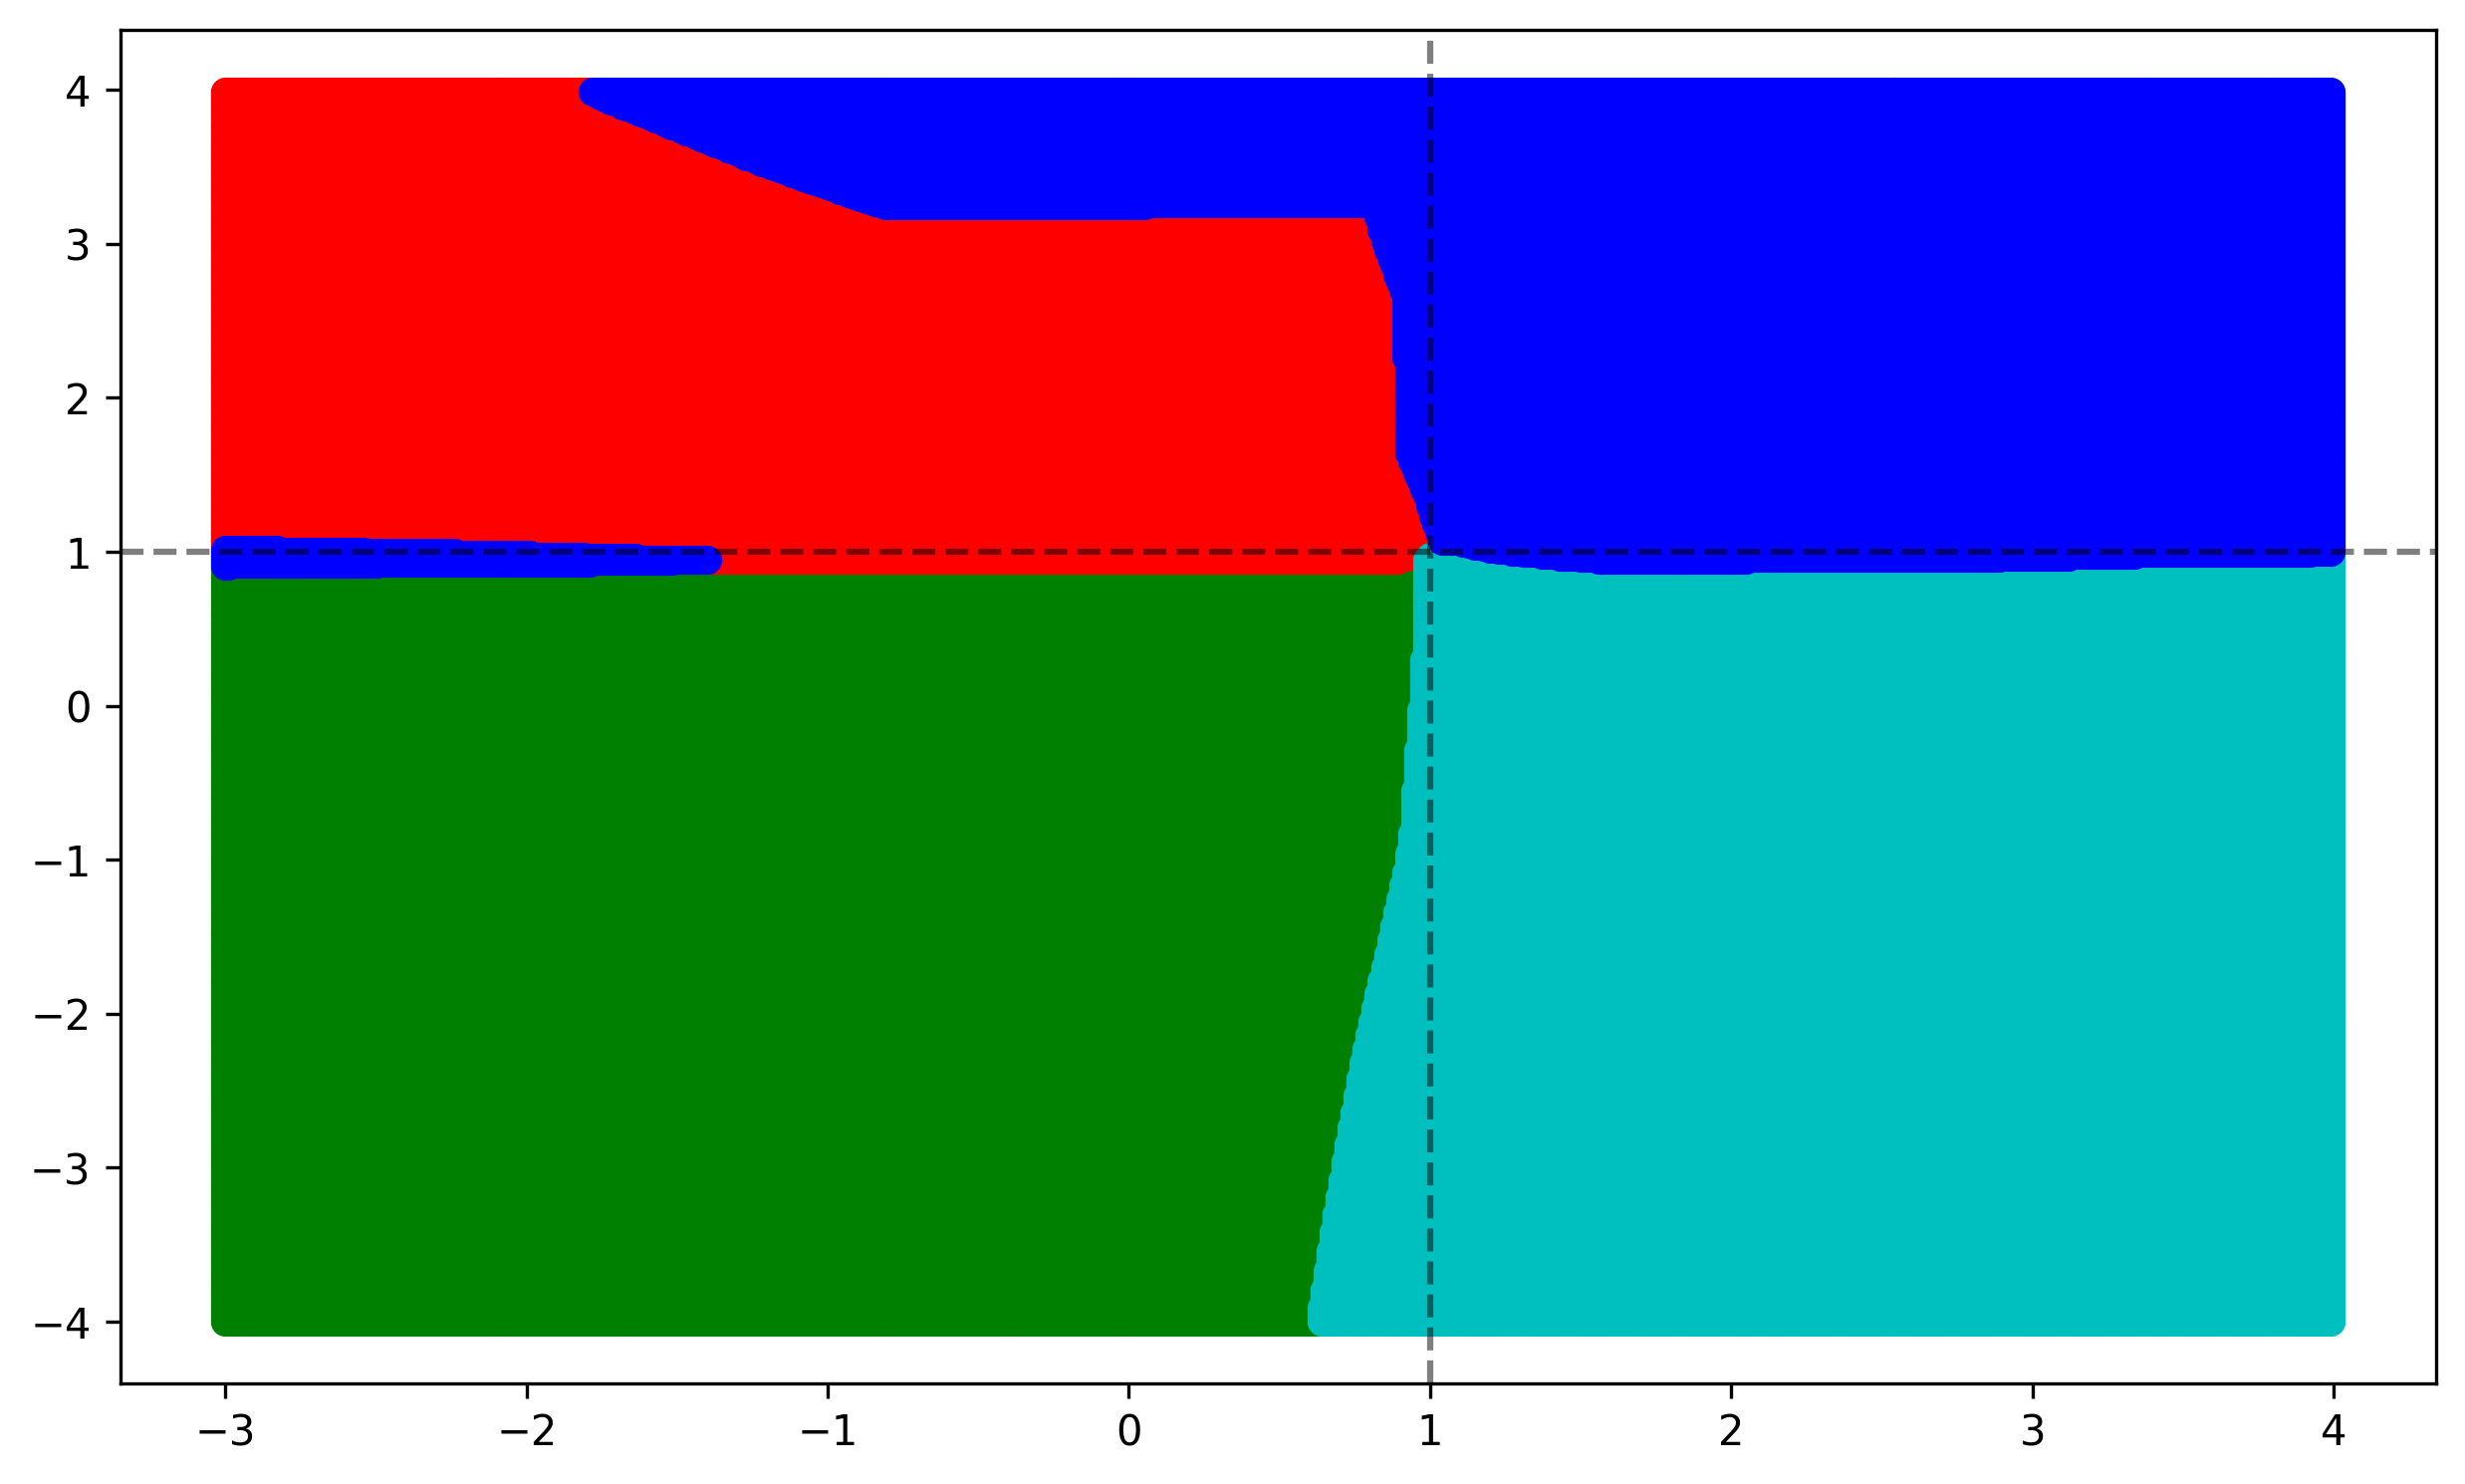

In [59]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)


colors = ['g', 'r', 'c', 'b', 'm', 'y', 'k']
# Plot each data point with its corresponding cluster color
for i, label in enumerate(unique_labels):
    cluster_data = mesh[predicted_clusters == label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[i], label=f'Cluster {label}')

plt.show()


## Predict new concepts for trajectories in our existing datasets using K-Means model

In [127]:
#Long running code
all_states = np.concatenate(trajectories)
state_wind = wind_predictor.predict(all_states)
state_wind = MinMaxScaler().fit_transform(state_wind) #should only fit this transform once all values have been predicted
state_value = v.predict(all_states)
state_value = MinMaxScaler().fit_transform(state_value)

In [128]:
kmeans_predicted_concepts = []
feature_vectors = []

index = 0
for i,traj in enumerate(trajectories):
    w_s, v_s  = state_wind[index:index+len(traj)], state_value[index:index+len(traj)] 
    index += len(traj)
    trajectory_action_distributions = pi_b.predict(traj)
    feature_vector = np.concatenate([trajectory_action_distributions, w_s, v_s], axis=1)
    feature_vectors.append(feature_vector)
    
feature_vectors_scaled = MinMaxScaler().fit_transform(np.concatenate(feature_vectors)) #must be done after all trajectories have been processed

In [129]:
index = 0
kmeans_predicted_concepts = []
for i,traj in enumerate(trajectories):
    predicted_concepts = kmeans.predict(feature_vectors_scaled[index:index+len(traj)])
    index+=len(traj)
    kmeans_predicted_concepts.append(predicted_concepts)

In [44]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

num_concepts = 4

def actions_to_action_indexes(actions):
    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]

    # action space
    A = np.array([up, down, right, left])

    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

def generate_default_concepts_dataset(window_size, concepts=concepts, trajectories=trajectories):
    Y = concepts
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, y_train, y_test

def generate_default_dataset(window_size, concepts=concepts):
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)

def generate_default_dataset_actions(window_size, actions=actions, trajectories=trajectories):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=5):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')


In [20]:
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow import keras
# from models.concept import ConceptModel

# X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5, concepts=kmeans_predicted_concepts)
# print(X_train.shape)
# print(y_train.shape)
# concept_model_kmeans = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
# history1 = concept_model_kmeans.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose = 1)
# concept_model_kmeans.save("saved_models/c_4_kmeans|s")
concept_model_kmeans = keras.models.load_model("saved_models/kmeans/c_4_kmeans|s") 

In [21]:
%%capture
index = 0
kmeans_predicted_concepts = []
for i,traj in enumerate(trajectories):
    predicted_concepts = np.argmax(concept_model_kmeans.predict(traj), axis=1)
    kmeans_predicted_concepts.append(predicted_concepts)

In [38]:
def plot_concept_decision_boundary(c_model, trajectories=None):
    h = .02  # step size in the mesh
    x_min, x_max = -4, 5
    y_min, y_max = -4.5,5.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = np.argmax(c_model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
    colors = ("blue","green","red","cyan","cyan","green")
    ax.contourf(xx, yy, Z, alpha=0.8, zorder=-1, colors=colors)
    points = np.array([[-3, -3], [-3, 3], [3, -3], [3, 3]])
    concepts = np.argmax(c_model.predict(points), axis=1)
    colors = ("blue","red","cyan","green")
    plt.plot(points[3,0], points[3,1], color = colors[concepts[3]], label=f"Concept {concepts[3]}")
    plt.plot(points[1,0], points[1,1], color = colors[concepts[1]], label=f"Concept {concepts[1]}")
    plt.plot(points[2,0], points[2,1], color = colors[concepts[2]], label=f"Concept {concepts[2]}")
    plt.plot(points[0,0], points[0,1], color = colors[concepts[0]], label=f"Concept {concepts[0]}")

    if trajectories is not None:
        for history in trajectories:
            plt.plot(history[:, 0], history[:, 1], alpha=0.05)
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 81ms/step
[3 1 2 0]


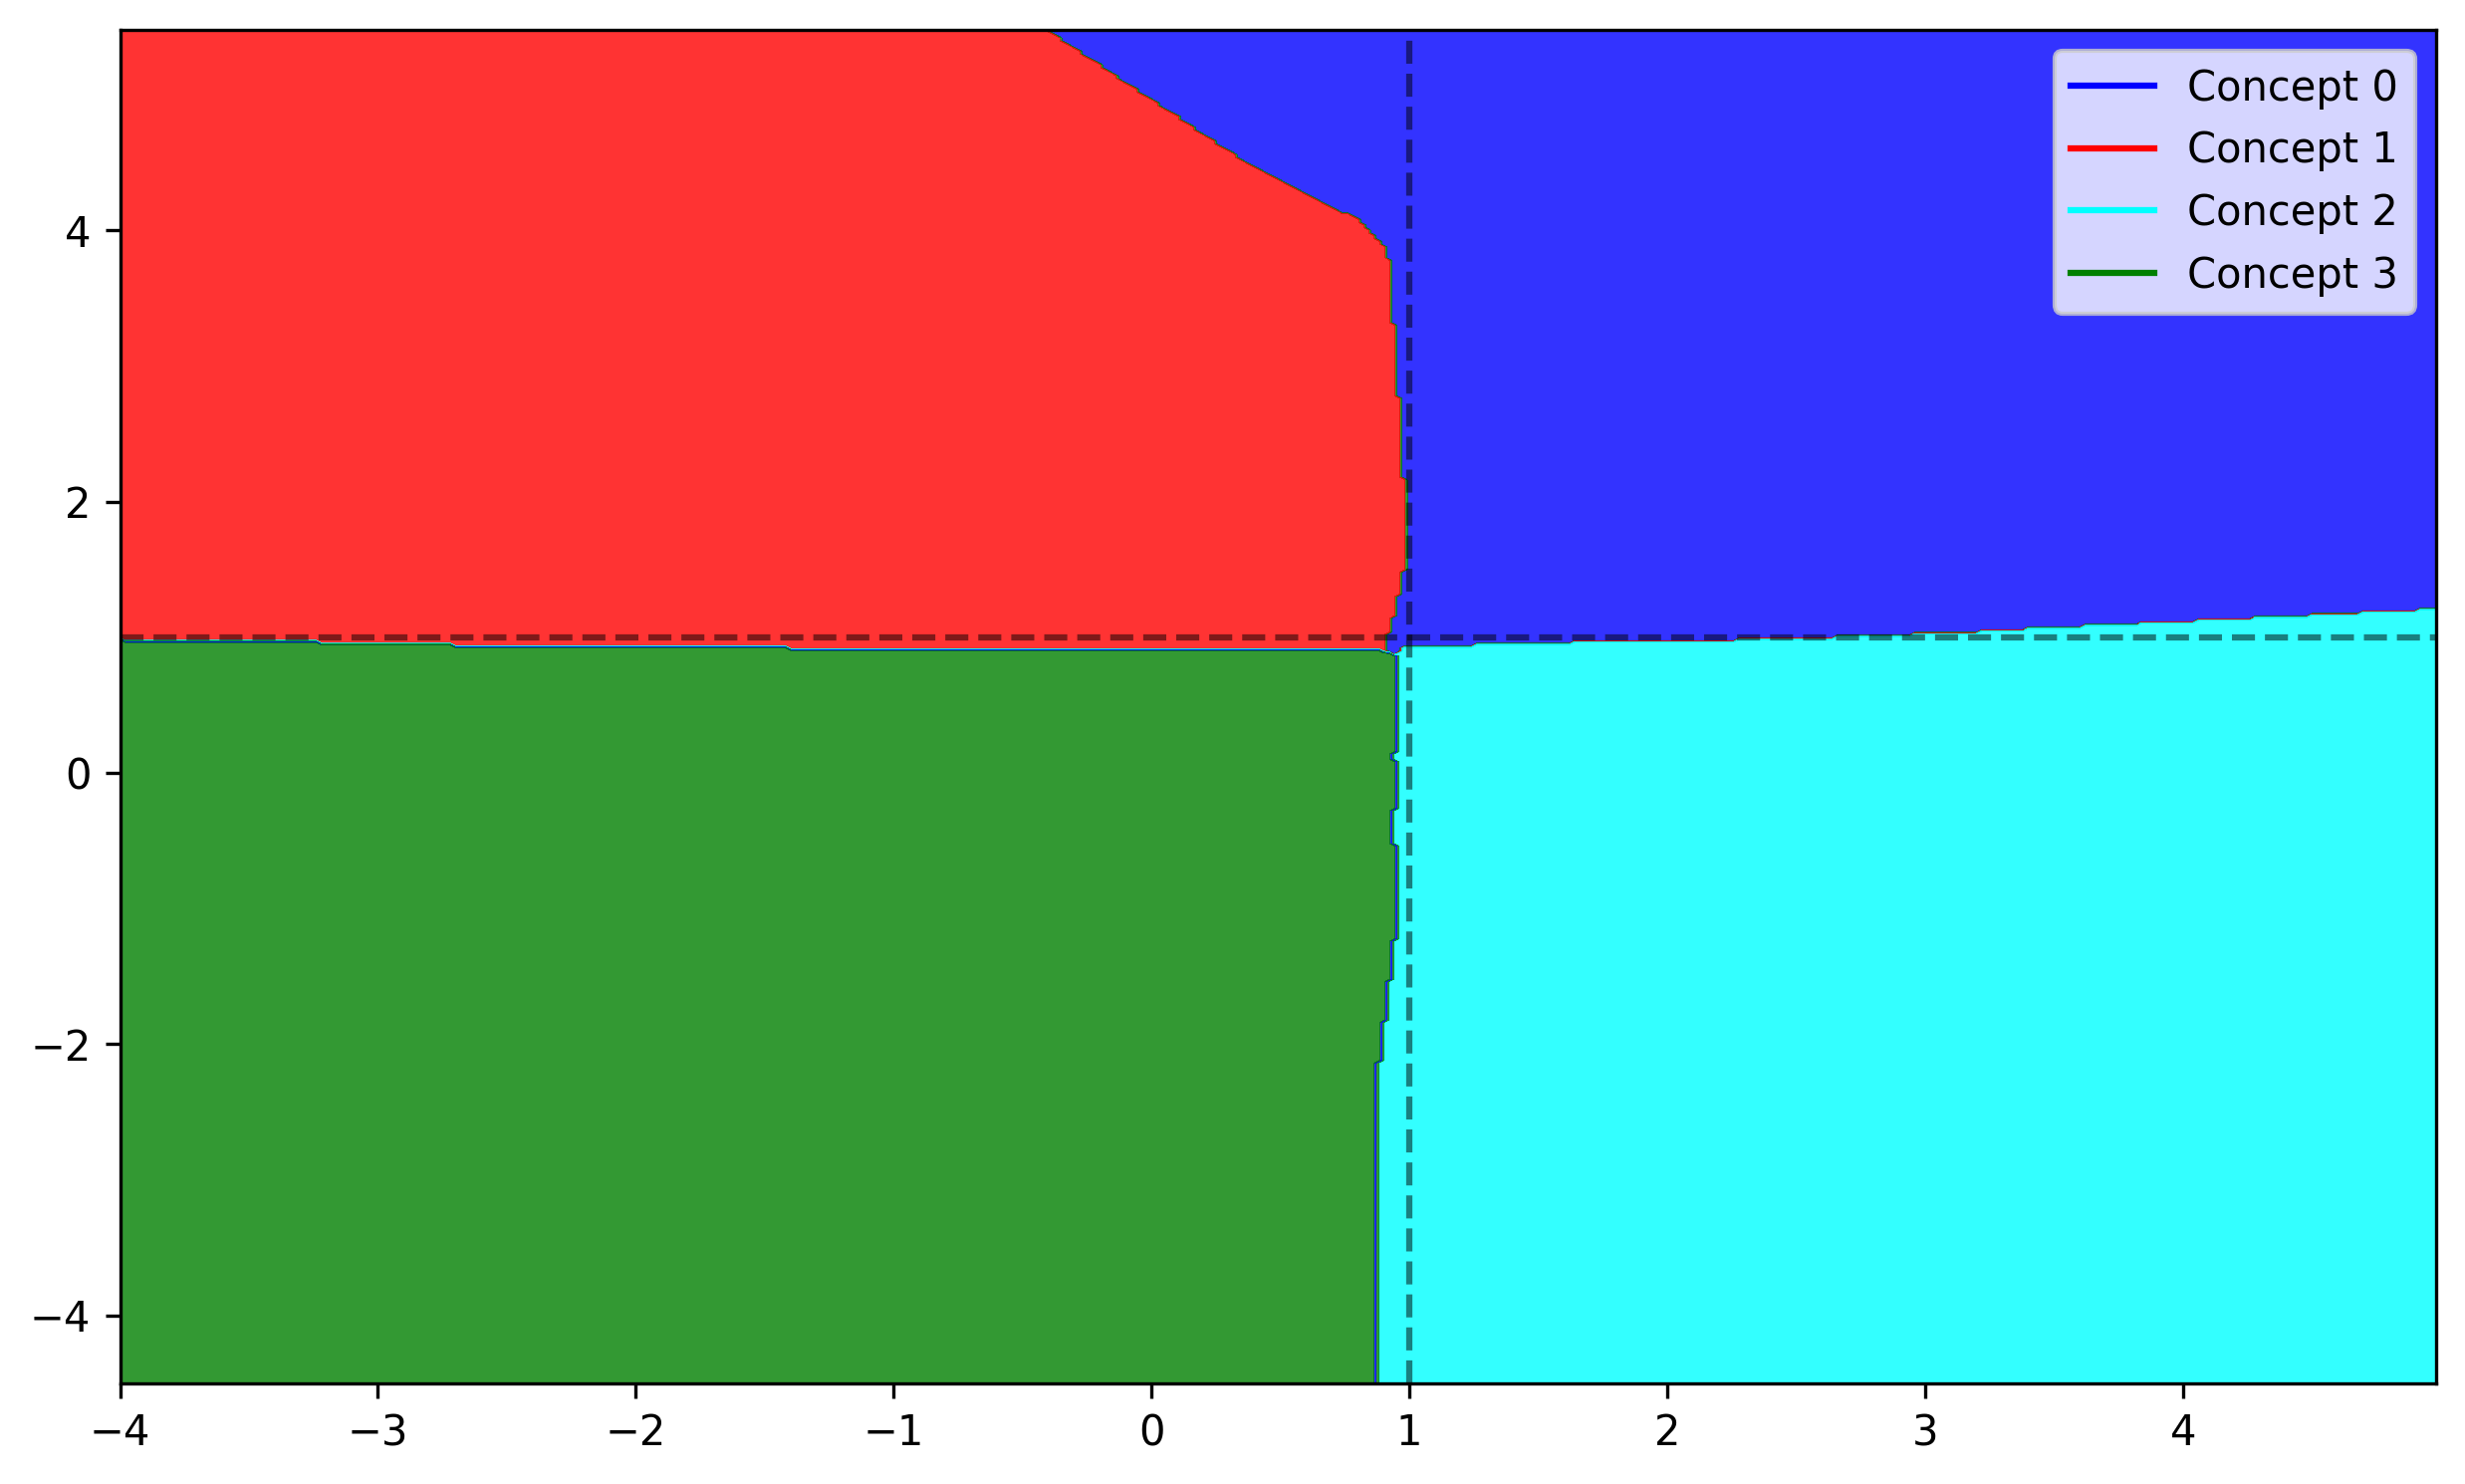

In [23]:
# load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')

# concept_model_opt = keras.models.load_model("saved_models/optimised/c_4_optimised_d900_mse|s")  
plot_concept_decision_boundary(concept_model_kmeans)

In [24]:
# from models.policy import PolicyModel
# X_train, X_test, y_train, y_test = generate_default_dataset_actions(window_size=5)
# #conver to concepts here
# concept_model_kmeans = keras.models.load_model("saved_models/c_4_kmeans|s")
# Xc_train = concept_model_kmeans.predict(X_train)
# Xc_test = concept_model_kmeans.predict(X_test)
# pi_b_c_kmeans = PolicyModel(input_size=Xc_train[0].shape, num_actions=4, loss="mse").build()
# history = pi_b_c_kmeans.fit(Xc_train, y_train, epochs=2, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b_c_kmeans.save("saved_models/pi_b_c_4_kmeans_reg")
pi_b_c_kmeans = keras.models.load_model("saved_models/kmeans/pi_b_c_4_kmeans")

In [25]:
pi_b_c_kmeans.predict(np.array([[0,1,0,0]]))

1/1 [==============================] - 0s 84ms/step


array([[0.21826522, 0.20030323, 0.5068024 , 0.07225458]], dtype=float32)

In [26]:
print(concept_model_kmeans.predict(np.array([[-3,-3]])))
print(pi_b_c_kmeans.predict(np.array([[0,0,0,1]])))


1/1 [==============================] - 0s 28ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 31ms/step
[[0.5412041  0.08221917 0.3106075  0.06825955]]


$$
\hat{V}_{IS}^{\pi_e}(\mathcal{D}) = \frac{1}{|\mathcal{D}|}\sum_{\tau \in \mathcal{D}} g(\tau)\rho(\tau)
$$
where
$$
\rho(\tau) = \prod_{t=1}^{T}\frac{\pi_e(a_t|c_t)}{\pi_b(a_t|c_t)}
$$
and
$$
g(\tau) = \sum_{t=1}^{T} \gamma^{t-1}r_t.
$$

Here $\gamma$ is the discount factor and $\tau \sim \pi_b$

## Optimizing concepts

- we need to minimize the MSE of our estimator w.r.t to the concepts
- decision variable: concept of every state in the above mesh? (this is huge). Or do we optimize the parameters of the kMeans?
- $MSE = Var[\hat{V}_{\pi_e}^c] + bias[\hat{V}_{\pi_e}^c]^2$
- $bias = \hat{V}_{\pi_e}^c - V_{on\ policy}$

In [27]:
D=900
indicies = np.random.choice(len(trajectories), D, replace=False)
sampled_trajectories = trajectories[indicies]
sampled_actions = actions[indicies]
sampled_concepts = np.array(kmeans_predicted_concepts, dtype="object")[indicies]
print(np.concatenate(sampled_trajectories).shape) # number of decision variables

(426883, 2)


In [47]:
print(pi_b_c_kmeans.predict(np.array([[0,1,0,0]])))

1/1 [==============================] - 0s 24ms/step
[[0.21826522 0.20030323 0.5068024  0.07225458]]


In [8]:
from autograd import grad, elementwise_grad
import copy
import autograd.numpy as np
from autograd.misc.optimizers import adam, sgd


def one_hot_decision_vector(predicted_concepts, num_concepts):
    predicted_concept_per_state = np.concatenate(predicted_concepts)
    v = np.zeros((len(predicted_concept_per_state), num_concepts))
    for i in range(len(v)):
        v[i][predicted_concept_per_state[i]] = 1.0
    return v

def eval_policy_by_region(state, behaviour_dist):
    x = state[0]
    y = state[1]
    epsilon = 1.0
    dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0] 
    if x > 1 and y > 1:
        return np.array([0.48, 0.02, 0.48, 0.02]) if dist_index == 1 else behaviour_dist
    elif x>1 and y<1:
        return np.array([0.53, 0.02, 0.35, 0.1]) if dist_index == 1 else behaviour_dist
    elif x<1 and y>1:
        return np.array([0.2, 0.2, 0.58, 0.02]) if dist_index == 1 else behaviour_dist
    else:
        return np.array([0.68, 0.02, 0.28, 0.02]) if dist_index == 1 else behaviour_dist


def eval_policy_by_concept(c, behaviour_dist):
    epsilon = 1.0
    dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0] 
    if c == 0:
        return np.array([0.48, 0.02, 0.48, 0.02]) if dist_index == 1 else behaviour_dist
    elif c == 2:
        return np.array([0.53, 0.02, 0.35, 0.1]) if dist_index == 1 else behaviour_dist
    elif c == 1:
        return np.array([0.2, 0.2, 0.58, 0.02]) if dist_index == 1 else behaviour_dist
    else:
        return np.array([0.68, 0.02, 0.28, 0.02]) if dist_index == 1 else behaviour_dist
    

def relu(x):
    return np.maximum(0.01, x)


def softmax(x):
    """applies softmax to an input x"""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtracting max along each row
    return e_x / e_x.sum(axis=1, keepdims=True)


pi_b_c_params = []
for i in range(len(pi_b_c_kmeans.layers)):
    layer_weights = pi_b_c_kmeans.layers[i].get_weights()
    pi_b_c_params.append(
        (layer_weights[0], layer_weights[1])
    )  # (Weights, bias) tuple for each layer


def predict_actions_from_concepts(params, input):
    for W, b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return output


v_on_policy = -347 #-477 , considering using the high reward for the on-policy policy


c = one_hot_decision_vector(sampled_concepts, num_concepts=4)
trajectory_lengths = np.array([len(traj) for traj in sampled_trajectories], dtype="object")
actions_indicies_taken = np.array([actions_to_action_indexes(actions) for actions in sampled_actions], dtype="object")

# behaviour_distrtibution_lookup = np.array([pi_b_c_kmeans.predict(np.array([concept_one_hot]))[0] for concept_one_hot in [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]])


def mse_loss(c, iter):
    """
    Input: decision_variables: a vector of one_hot encodings of the concept at every state in the dataset. Shape: (sum(len(traj) in D) x num_concepts)

    Other required paramaters (which can't be passed in as arguments due to Autograd's workings)
    - trajectory_lengths: a list of the lengths of each trajectory in the dataset
    - actions_taken: a list of the actions taken at each state in the dataset (index of action in the action space)
    - v_on_policy
    - pi_b_c: the behaviour policy model over concepts: concept one_hot -> action distribution
    - eval_policy: possibly a function to introduce eval_policy randomly
    """
    index = 0
    V_hat = 0
    estimates = []
    for i, traj in enumerate(sampled_trajectories):
        """
        Compute squared error for each trajectory before taking mean
        """
        T = len(traj)
        decision_variables_for_trajectory = c[index : index + T]
        index += T

        denominator = predict_actions_from_concepts(pi_b_c_params, decision_variables_for_trajectory)
        r, _ = denominator.shape
        denominator_probabilities = denominator[np.arange(r), actions_indicies_taken[i]]
        concepts_for_trajectory = np.argmax(decision_variables_for_trajectory, axis=1)
        numerator = np.array([eval_policy_by_concept(c, denominator[j]) for j,c in enumerate(concepts_for_trajectory)])
        r, _ = numerator.shape
        numerator_probabilities = numerator[np.arange(r), actions_indicies_taken[i]]
     
        ratios = (numerator_probabilities / denominator_probabilities)  # importance sampling ratios
        cumprod = np.array([np.prod(ratios[0:i+1]) for i in range(len(ratios))]) #equivalent to np.cumrpod which has no gradient implemented in autograd. This is for PDIS
      
        importance_weight = np.sum(cumprod)
       
        V = importance_weight * -1  # per trajectory estimate (i.e. D=1)
        estimates.append(V)
        V_hat = V_hat + V
       
    std = np.std(np.array(estimates))
    V_hat = V_hat/len(sampled_trajectories)

    return  (v_on_policy - V_hat)**2 + std**2


loss_gradient = grad(mse_loss)

# print(mse_loss(c, 0))

print("     Epoch     |    MSE")
def print_perf(params, iter, gradient):
    mse = mse_loss(params, iter)
    print("{:15}|{:20}".format(iter, mse))

objective_grad = grad(mse_loss)
optimized_params = adam(objective_grad, c, step_size=0.001, num_iters=50, callback=print_perf)

NameError: name 'sampled_concepts' is not defined

#### Now retrain a concept model with new optimised concepts at each state
- necesarry since we will need the pi_b_c_optimised predictor for running OPE

In [49]:
from keras.models import Sequential
from keras.layers import Dense
class ConceptModel():
    model = None

    def __init__(self, input_size, num_concepts) -> None:
        self.input_size = input_size
        self.output_size = num_concepts
    
    def build(self):
        model = Sequential()
        model.add(Dense(64, activation="relu", input_shape=self.input_size))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_size, activation="linear"))

        model.compile(optimizer='adam',loss='mse', metrics=['mse'])
        self.model = model
        return model

In [50]:

X_train, X_test, y_train, y_test = generate_default_concepts_dataset(window_size=5, concepts=optimized_params, trajectories=sampled_trajectories)
print(X_train.shape)
print(y_train.shape)
concept_model_optimised = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history1 = concept_model_optimised.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose = 1)
# concept_model_optimised.save("saved_models/optimised/c_4_optimised_d900_std|s")
# concept_model_optimised = keras.models.load_model("saved_models/c_4_optimised|s")

(37960, 2)
(37960, 4)
Epoch 1/5
949/949 [==============================] - 3s 2ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 2/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 3/5
949/949 [==============================] - 1s 1ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 4/5
949/949 [==============================] - 1s 1ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5/5
949/949 [==============================] - 1s 1ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0076 - val_mse: 0.0076


7032/7032 [==============================] - 7s 968us/step


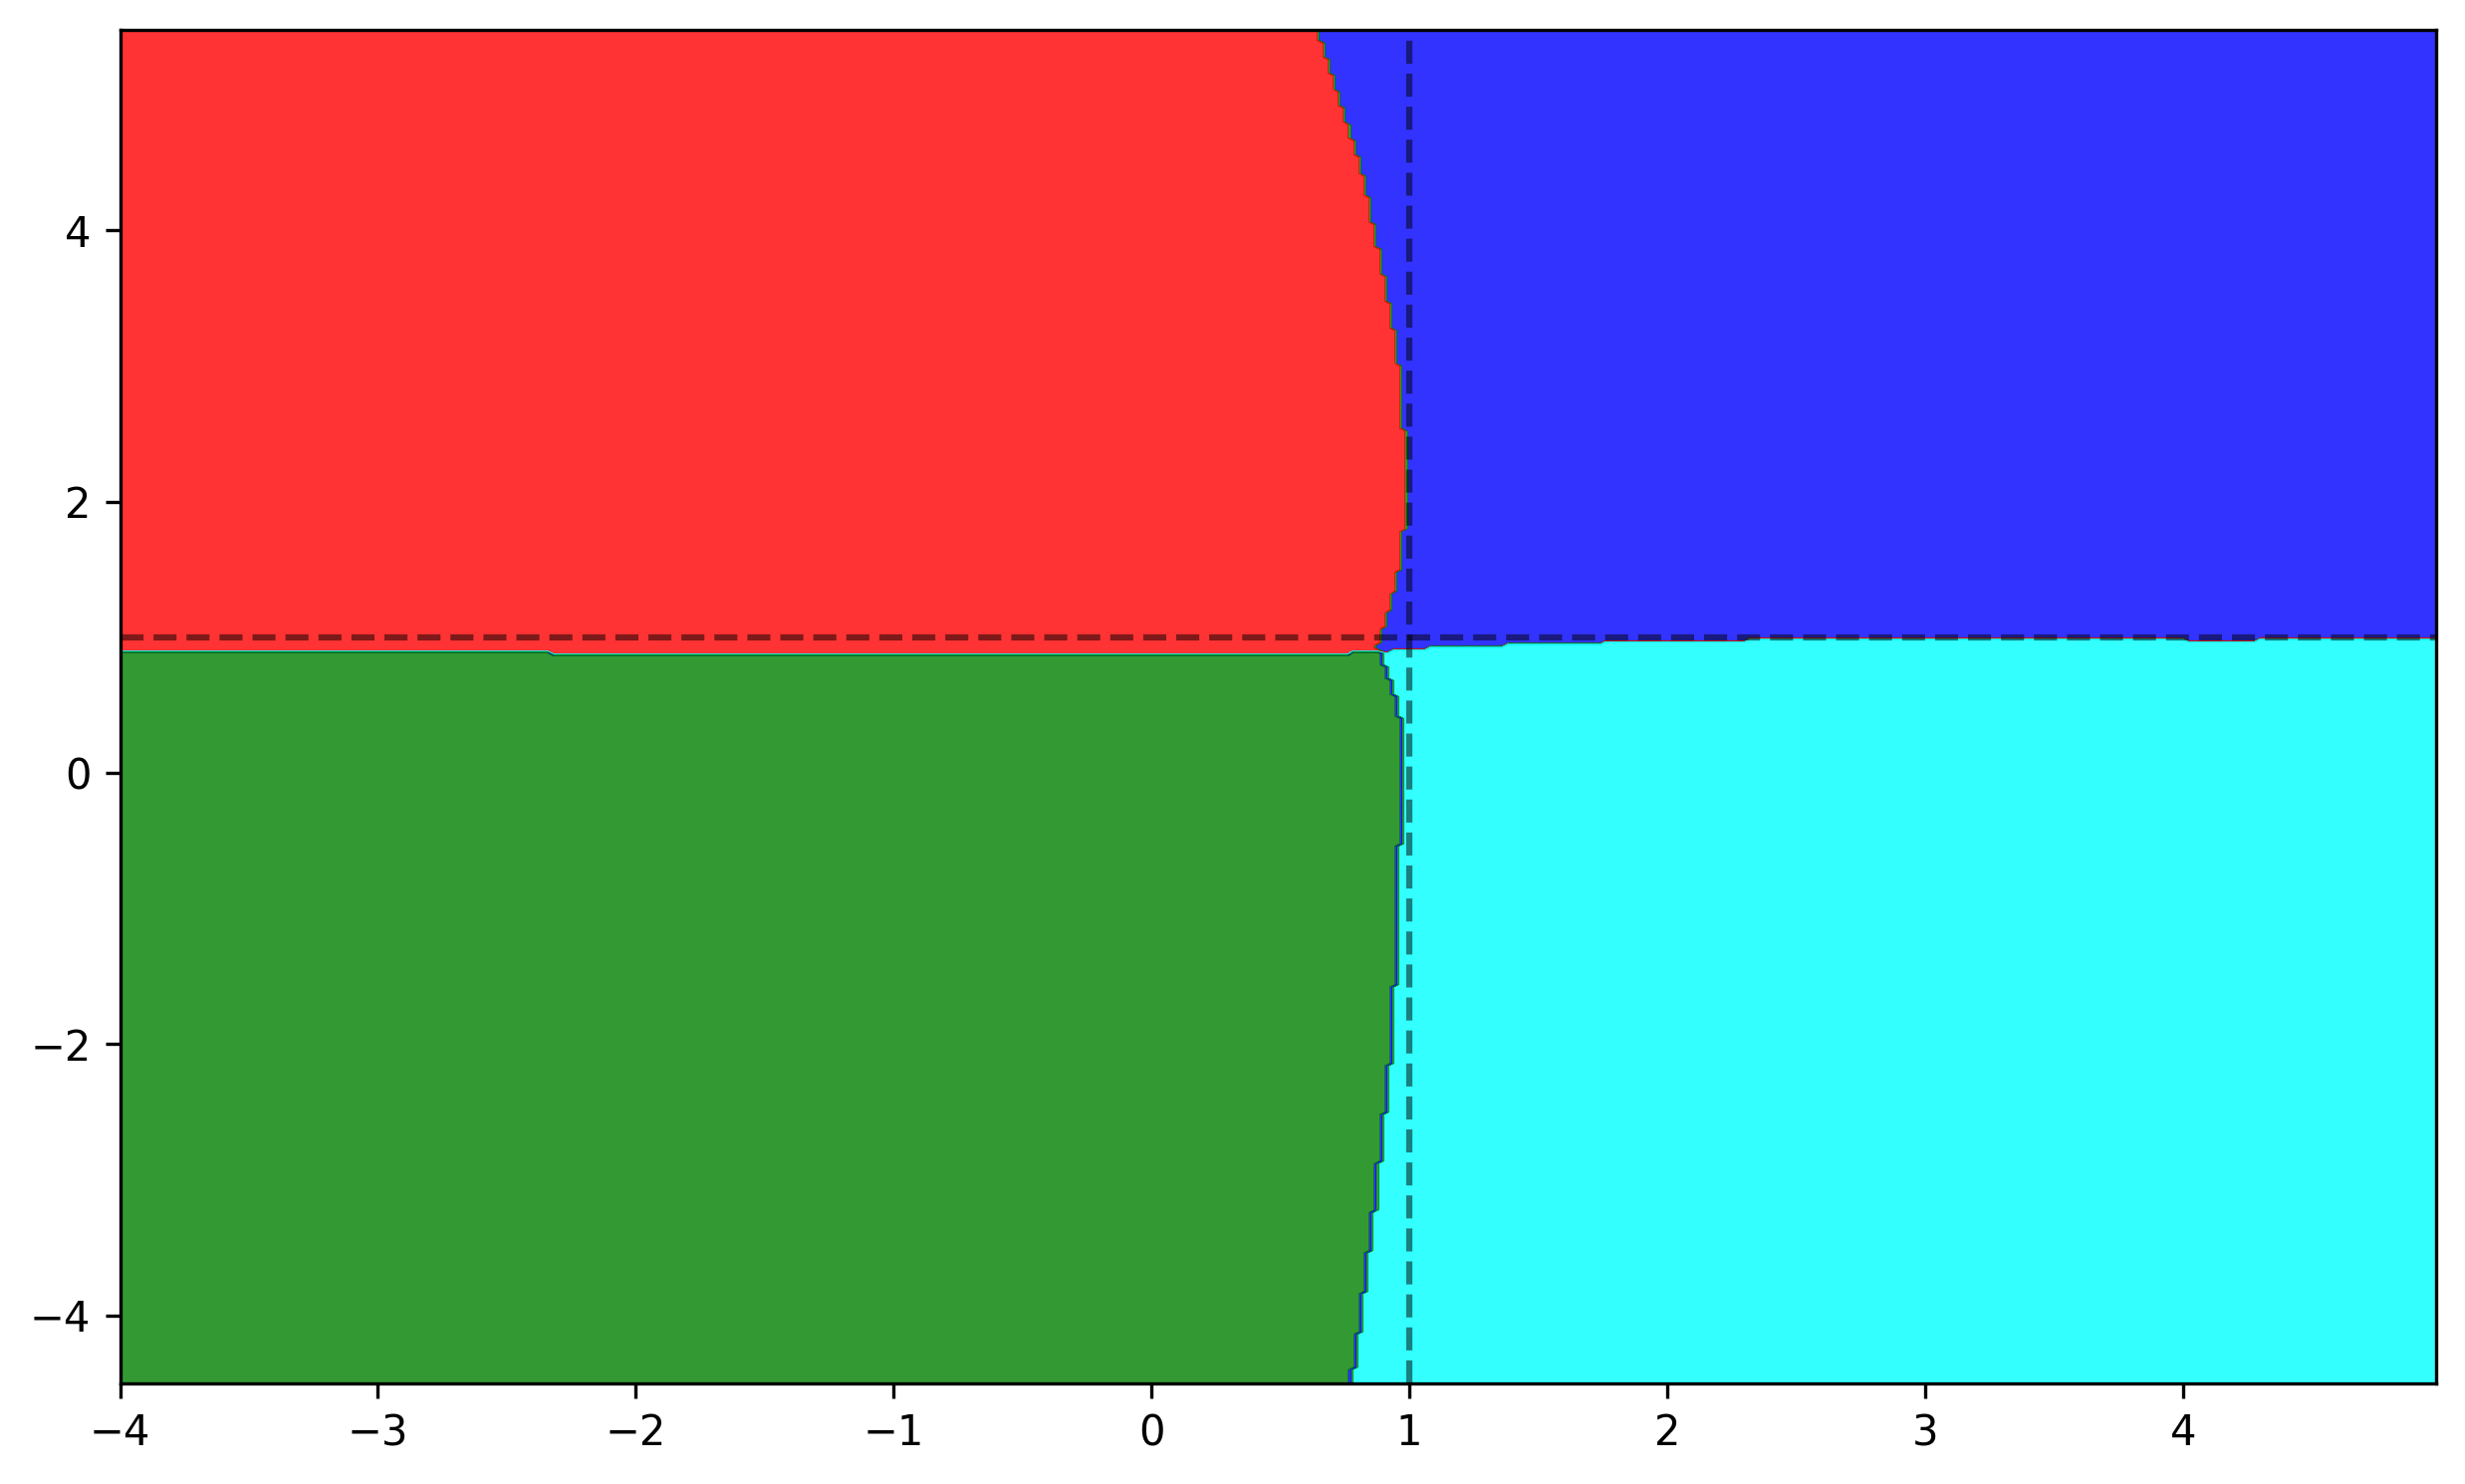

In [51]:
# concept_model_optimised = keras.models.load_model("saved_models/c_4_optimised|s")
# concept_model_optimised.save("saved_models/optimised/c_4_optimised_d900_std|s")
plot_concept_decision_boundary(concept_model_optimised)

In [43]:
from models.policy import PolicyModel
X_train, X_test, y_train, y_test = generate_default_dataset_actions(window_size=5, actions=sampled_actions, trajectories=sampled_trajectories)
#conver to concepts here
concept_model_optimised = keras.models.load_model("saved_models/optimised/c_4_optimised_d900_std|s")
Xc_train = concept_model_optimised.predict(X_train)
Xc_test = concept_model_optimised.predict(X_test)
pi_b_c_optimised = PolicyModel(input_size=Xc_train[0].shape, num_actions=4, loss="mse").build()
history = pi_b_c_optimised.fit(Xc_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
pi_b_c_optimised.save("saved_models/optimised/pi_b_c_optimised_d900_std")

2696/2696 [==============================] - 2s 794us/step
Epoch 1/15
8627/8627 [==============================] - 12s 1ms/step - loss: 0.1588 - mse: 0.1588 - val_loss: 0.1588 - val_mse: 0.1588
Epoch 2/15
8627/8627 [==============================] - 11s 1ms/step - loss: 0.1585 - mse: 0.1585 - val_loss: 0.1582 - val_mse: 0.1582
Epoch 3/15
8627/8627 [==============================] - 11s 1ms/step - loss: 0.1585 - mse: 0.1585 - val_loss: 0.1581 - val_mse: 0.1581
Epoch 4/15
8627/8627 [==============================] - 11s 1ms/step - loss: 0.1584 - mse: 0.1584 - val_loss: 0.1582 - val_mse: 0.1582
Epoch 5/15
8627/8627 [==============================] - 11s 1ms/step - loss: 0.1584 - mse: 0.1584 - val_loss: 0.1581 - val_mse: 0.1581
Epoch 6/15
8627/8627 [==============================] - 11s 1ms/step - loss: 0.1584 - mse: 0.1584 - val_loss: 0.1580 - val_mse: 0.1580
Epoch 7/15
8627/8627 [==============================] - 11s 1ms/step - loss: 0.1584 - mse: 0.1584 - val_loss: 0.1582 - val_mse: 0.1

INFO:tensorflow:Assets written to: saved_models/optimised/pi_b_c_optimised_d900_std/assets


In [44]:
pi_b_c_optimised.predict(np.array([[0,1,0,0]]))

1/1 [==============================] - 0s 78ms/step


array([[0.24951637, 0.20444728, 0.4906428 , 0.06504565]], dtype=float32)

## Try optimize weights of states -> concept predictor instead

In [85]:
D=100
indicies = np.random.choice(len(trajectories), D, replace=False)
sampled_trajectories = trajectories[indicies]
sampled_actions = actions[indicies]
print(np.concatenate(sampled_trajectories).shape) # number of decision variables

(47536, 2)


In [45]:
#load here to perform more iterations on existing optimised model
concept_model_kmeans = keras.models.load_model("saved_models/kmeans/c_4_kmeans_holdout|s") 
pi_b_c_kmeans = keras.models.load_model("saved_models/kmeans/pi_b_c_4_kmeans_holdout")

In [46]:
from autograd import grad, elementwise_grad
import copy
from autograd.misc.optimizers import adam
import autograd.numpy as np #important

def eval_policy_by_region(state, behaviour_dist):
    x = state[0]
    y = state[1]
    epsilon = 1.0
    dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0] 
    if x > 1 and y > 1:
        return np.array([0.48, 0.02, 0.48, 0.02]) if dist_index == 1 else behaviour_dist
    elif x>1 and y<1:
        return np.array([0.53, 0.02, 0.35, 0.1]) if dist_index == 1 else behaviour_dist
    elif x<1 and y>1:
        return np.array([0.2, 0.2, 0.58, 0.02]) if dist_index == 1 else behaviour_dist
    else:
        return np.array([0.68, 0.02, 0.28, 0.02]) if dist_index == 1 else behaviour_dist


def eval_policy_by_concept(c, behaviour_dist):
    epsilon = 0.5
    dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0] 
    if c == 0:
        return np.array([0.48, 0.02, 0.48, 0.02]) if dist_index == 1 else behaviour_dist
    elif c == 2:
        return np.array([0.53, 0.02, 0.35, 0.1]) if dist_index == 1 else behaviour_dist
    elif c == 1:
        return np.array([0.2, 0.2, 0.58, 0.02]) if dist_index == 1 else behaviour_dist
    else:
        return np.array([0.68, 0.02, 0.28, 0.02]) if dist_index == 1 else behaviour_dist


def relu(x):
    return np.maximum(0, x)

def softmax(x):
    """ applies softmax to an input x"""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtracting max along each row
    return e_x / e_x.sum(axis=1, keepdims=True)

pi_b_c_params = []
for i in range(len(pi_b_c_kmeans.layers)):
    layer_weights = pi_b_c_kmeans.layers[i].get_weights()
    pi_b_c_params.append((layer_weights[0], layer_weights[1])) #(Weights, bias) tuple for each layer


concept_model_params = []
for i in range(len(concept_model_kmeans.layers)):
    layer_weights = concept_model_kmeans.layers[i].get_weights()
    concept_model_params.append((layer_weights[0], layer_weights[1])) #(Weights, bias) tuple for each layer

def predict_concept_from_states(params, input):
    for W,b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return softmax(output)

def predict_actions_from_concepts(params, input):
    for W,b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return output

    
v_on_policy = -347 #-347 -423
# actions_indicies_taken = np.array([actions_to_action_indexes(actions) for actions in sampled_actions], dtype="object")


def mse_loss(concept_model_params, iter):
    '''
    Input: decision_variables: a vector of one_hot encodings of the concept at every state in the dataset. Shape: (sum(len(traj) in D) x num_concepts)

    Other required paramaters (which can't be passed in as arguments due to Autograd's workings)
    - trajectory_lengths: a list of the lengths of each trajectory in the dataset
    - actions_taken: a list of the actions taken at each state in the dataset (index of action in the action space)
    - v_on_policy
    - pi_b_c: the behaviour policy model over concepts: concept one_hot -> action distribution
    - eval_policy: possibly a function to introduce eval_policy randomly
    '''
    np.random.seed((iter//5)*10)
    D=100
    heldout_trajectory_indicies = np.arange(2720, len(trajectories), 1)
    indicies = np.random.choice(heldout_trajectory_indicies, D, replace=False)
    sampled_trajectories = trajectories[indicies]
    sampled_actions = actions[indicies]
    actions_indicies_taken = np.array([actions_to_action_indexes(actions) for actions in sampled_actions], dtype="object")

    N_trials = 10
    estimate_per_trial = []
    for N in range(N_trials):

      
        V_hat = 0
        estimates = []
        for i, traj in enumerate(sampled_trajectories):
            '''
            Compute squared error for each trajectory before taking mean
            '''
            T = len(traj)
            # decision_variables_for_trajectory = c[index:index+T]
            
            trajectory_concepts = predict_concept_from_states(concept_model_params, traj)
            trajectory_action_distributions = predict_actions_from_concepts(pi_b_c_params, trajectory_concepts) #behaviour distributions

            r,_ = trajectory_action_distributions.shape
            denominator_probabilities = trajectory_action_distributions[np.arange(r), actions_indicies_taken[i]] #pi_b
            numerator = np.array([eval_policy_by_concept(c, trajectory_action_distributions[j]) for j,c in  enumerate(np.argmax(trajectory_concepts, axis=1))])
            # numerator = np.array([eval_policy_by_concept(c, trajectory_action_distributions[j]) for j,c in  enumerate(ntrajectory_concepts)]) #eval policy by region

            r,_ = numerator.shape
            numerator_probabilities = numerator[np.arange(r), actions_indicies_taken[i]] #pi_e

            #PDIS    
            ratios = (numerator_probabilities / denominator_probabilities)  # importance sampling ratios
            cumprod = np.array([np.prod(ratios[0:i+1]) for i in range(len(ratios))]) #equivalent to np.cumrpod which has no gradient implemented in autograd. This is for PDIS
            importance_weight = np.sum(cumprod)

            V = importance_weight * -1  # per trajectory estimate (i.e. D=1)
            estimates.append(V)
            
            # V_hat = V_hat + V
        estimate_per_trial.append(np.array(estimates).mean())
       
    std = np.std(np.array(estimate_per_trial))
    V_hat = np.array(estimate_per_trial).mean()
    # V_hat = V_hat/len(sampled_trajectories)
    return  (v_on_policy - V_hat)**2 + std**2 #bias^2 + variance


print("     Epoch     |    MSE")
def print_perf(params, iter, gradient):
    mse = mse_loss(params,iter)
    print("{:15}|{:20}".format(iter, mse))

objective_grad = grad(mse_loss)
optimized_params = adam(objective_grad, concept_model_params, step_size=0.001, num_iters=500, callback=print_perf)
  

     Epoch     |    MSE
              0|  22073.145680219557
              1|   22344.84658891498
              2|  23085.288308119045
              3|  22861.689614497882
              4|  22594.640990187407
              5|  30028.332492905425
              6|   36970.50638282474
              7|   33915.69820222938
              8|  38866.777011253645
              9|  41608.476782205486
             10|  13025.282332147286
             11|  13111.020129838487
             12|  13983.654181936334
             13|  14071.646316964594
             14|   14090.34445634292
             15|  25696.921864699612
             16|  25379.078190425713
             17|  25356.797324417344
             18|  25088.276498497726
             19|   24879.41875291812
             20|  19602.493162675768
             21|   19565.94925983607
             22|  19455.472576967713
             23|   19431.66635361744
             24|  20468.652122287138
             25|  45184.498338474485
             2

In [47]:
l1 = optimized_params[0] #W,b
l2 = optimized_params[1] #W,b
l3 = optimized_params[2] #W,b


concept_model_params_optimised = keras.models.load_model("saved_models/optimised/c_4_optimised|s")

concept_model_params_optimised.layers[0].set_weights(list(l1))
concept_model_params_optimised.layers[1].set_weights(list(l2))
concept_model_params_optimised.layers[2].set_weights(list(l3))


In [70]:
pi_b_model_params_optimised.predict(np.array([[0,0,1,0]]))

1/1 [==============================] - 0s 183ms/step


array([[0.3067611 , 0.20829064, 0.2640135 , 0.22093485]], dtype=float32)

In [49]:
concept_model_params_optimised.save("saved_models/optimised_holdout/c_4_optimised_params_eps05_d100sampled5_n500_a001|s")
# pi_b_model_params_optimised.save("saved_models/optimised/pi_b_c_optimised_params_std")

INFO:tensorflow:Assets written to: saved_models/optimised_holdout/c_4_optimised_params_eps05_d100sampled5_n500_a001|s/assets


INFO:tensorflow:Assets written to: saved_models/optimised_holdout/c_4_optimised_params_eps05_d100sampled5_n500_a001|s/assets


: 

1/1 [==============================] - 0s 97ms/step


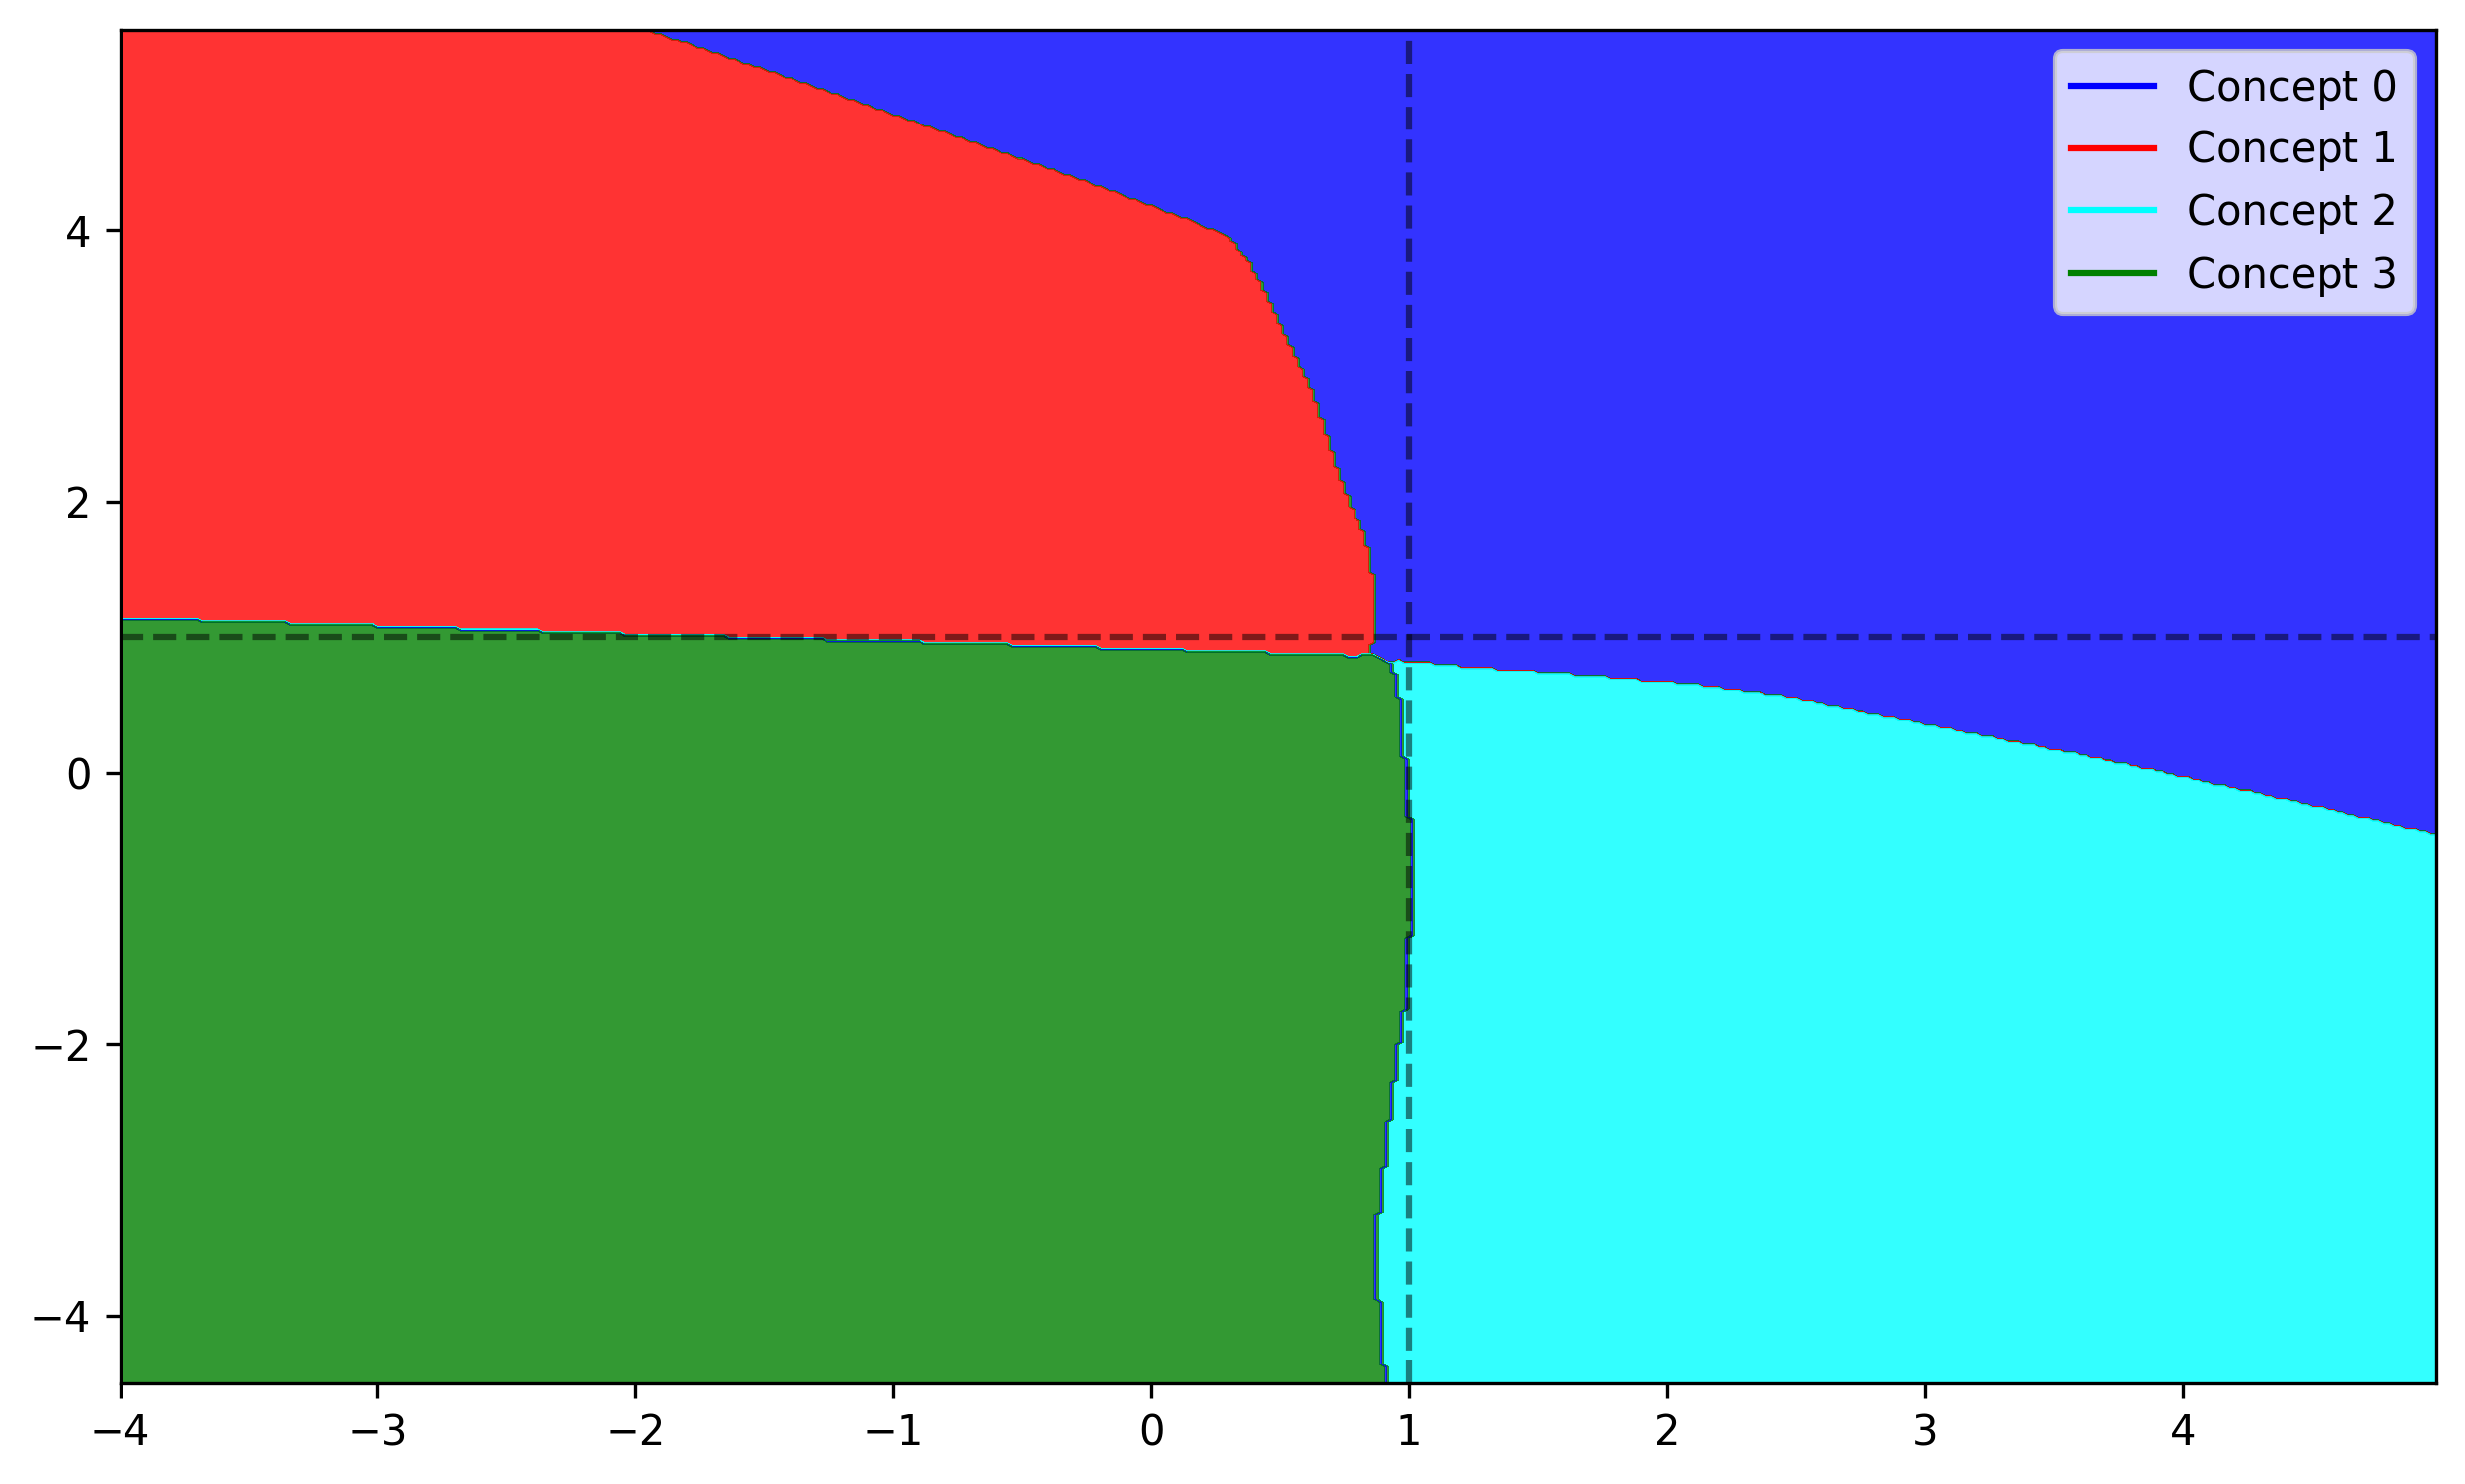

In [48]:
plot_concept_decision_boundary(concept_model_params_optimised)

1/1 [==============================] - 0s 81ms/step


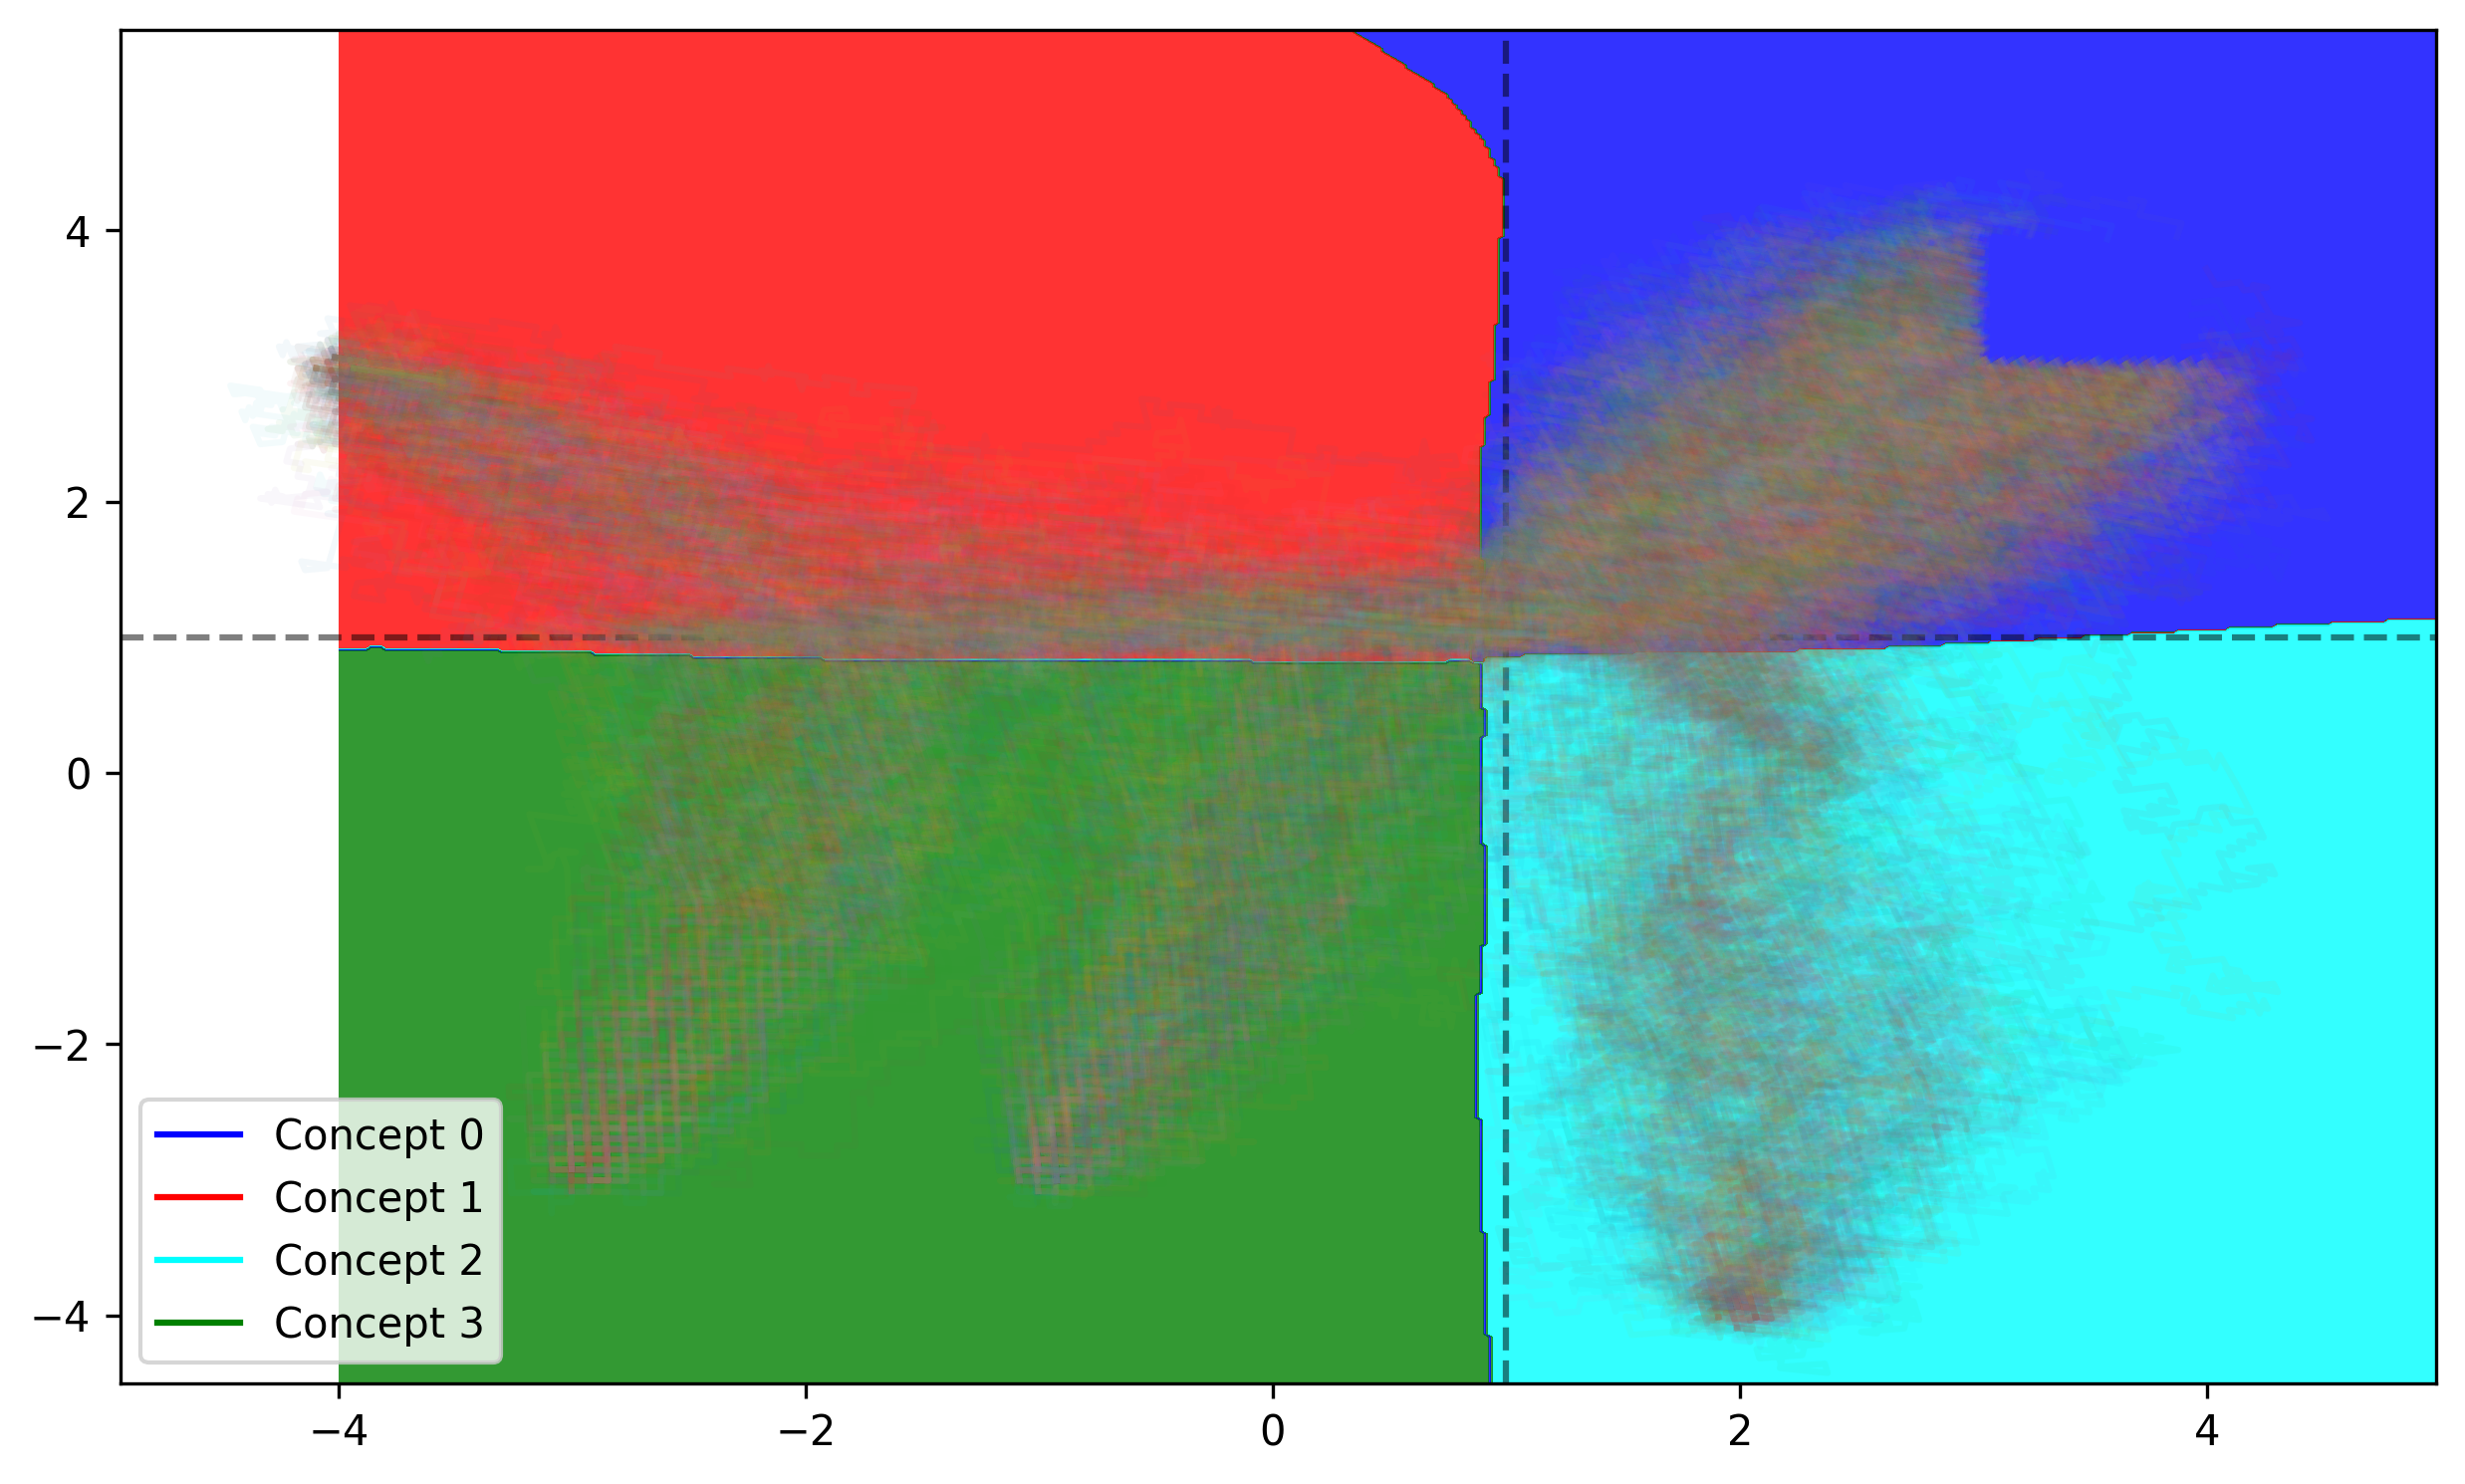

In [40]:
concept_model_kmeans = keras.models.load_model("saved_models/optimised_stochastic/c_4_optimised_params_a001_n150_d100sampled_eps02_new_mse_trials_std|s") 
plot_concept_decision_boundary(concept_model_kmeans, trajectories=sampled_trajectories)